# Imports

In [2]:
import numpy as np
import pandas as pd

import os

import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap

import seaborn as sns

from glob import glob

from tqdm.notebook import tqdm
tqdm.pandas()

# Global variables

In [3]:
DIR_PATH = "/kaggle/input/uw-madison-gi-tract-image-segmentation/"

pd.set_option('display.max_colwidth', 400) 

CMAP1 = ListedColormap([[0, 0, 0, 0], [1, 0, 0, 1]])  # black transparent, red opaque
CMAP2 = ListedColormap([[0, 0, 0, 0], [0, 1, 0, 1]])  # black transparent, green opaque
CMAP3 = ListedColormap([[0, 0, 0, 0], [0, 0, 1, 1]])  # black transparent, blue opaque

# Data Preprocessing & EDA

In [4]:
data = pd.read_csv(DIR_PATH + "train.csv")
data.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [5]:
data_nonnaseg = data.loc[data.segmentation.notna(), :]
data_nonnaseg.head()

,id,class,segmentation
194,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 9 29687 9 29953 9 30219 9 30484 10 30750 10 31016 10 31282 10 31548 10 31814 10 32081 9 32347 8 32614 6
197,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28886 15 29151 17 29417 17 29682 18 29948 18 30214 18 30480 18 30746 18 31012 18 31278 18 31544 18 31811 17 32077 17 32344 15 32610 15 32877 13 33144 11 33411 8
200,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 16649 12 16915 12 17181 12 17447 12 17713 12 17979 12 18245 12 18511 12 18777 12 19043 12 19309 12 19575 12 19841 12 20107 12 20373 12 20639 12 20905 12 21171 12 21437 12 21703 12 21969 12 22235 12 22501 12 22767 12 23033 12 23299 12 23565 12 23831 12 24097 12 24363 12 24629 12 24895 12 25161 13 25427 13 25693 14 25959 14 26224 15 26489 16 26755 17 27...
203,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 16118 13 16383 15 16649 15 16915 15 17180 16 17446 16 17712 16 17978 16 18244 16 18510 16 18776 16 19042 16 19308 16 19574 16 19840 16 20106 16 20372 16 20638 16 20904 16 21170 16 21436 16 21702 16 21968 16 22234 16 22500 16 22766 16 23032 16 23298 17 23564 17 23830 17 24096 17 24362 17 24628 17 24894 17 25159 18 25425 18 25691 19 25956 20 26221 21 26...
206,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15850 18 16115 19 16381 19 16646 20 16912 20 17178 20 17444 20 17710 20 17976 20 18242 20 18508 20 18774 20 19040 20 19306 20 19572 20 19838 20 20104 20 20370 20 20636 20 20902 20 21168 20 21434 20 21700 20 21966 20 22232 20 22499 19 22765 19 23030 20 23296 20 23562 20 23827 21 24093 21 24359 22 24625 22 24891 22 25156 23 25422 24 25688 24 25954 24 2...


In [6]:
data[['case', 'day', 'slice']] = data['id'].str.extract(r'case(\d+)_day(\d+)_slice_(\d+)')
data

,id,class,segmentation,case,day,slice
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001
2,case123_day20_slice_0001,stomach,NaN,123,20,0001
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002
...,...,...,...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN,30,0,0143
115484,case30_day0_slice_0143,stomach,NaN,30,0,0143
115485,case30_day0_slice_0144,large_bowel,NaN,30,0,0144
115486,case30_day0_slice_0144,small_bowel,NaN,30,0,0144


In [7]:
paths = glob(DIR_PATH + 'train/*/*/*/*')
path_df = pd.DataFrame(paths, columns=['image_path'])

# The image file corresponding to case123_day20_slice_0065 is train/case123/case123_day20/scans/slice_0065_266_266_1.50_1.50.png 
# 266, 266 are slice width, slice height and 1.5, 1.5 are pixel width, pixel height.

path_df[['case', 'day', 'slice', 
         'slice_w', 'slice_h', 
         'px_w', 'px_h']] = \
        path_df.image_path.str.extract(r'.*/case(\d+)_day(\d+)/scans/slice_(\d+)_(\d+)_(\d+)_(\d+\.\d+)_(\d+\.\d+)\.png')
path_df

,image_path,case,day,slice,slice_w,slice_h,px_w,px_h
0,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0006_266_266_1.50_1.50.png,36,14,0006,266,266,1.50,1.50
1,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0082_266_266_1.50_1.50.png,36,14,0082,266,266,1.50,1.50
2,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0113_266_266_1.50_1.50.png,36,14,0113,266,266,1.50,1.50
3,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0076_266_266_1.50_1.50.png,36,14,0076,266,266,1.50,1.50
4,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0125_266_266_1.50_1.50.png,36,14,0125,266,266,1.50,1.50
...,...,...,...,...,...,...,...,...
38491,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case33/case33_day21/scans/slice_0045_266_266_1.50_1.50.png,33,21,0045,266,266,1.50,1.50
38492,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case33/case33_day21/scans/slice_0027_266_266_1.50_1.50.png,33,21,0027,266,266,1.50,1.50
38493,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case33/case33_day21/scans/slice_0089_266_266_1.50_1.50.png,33,21,0089,266,266,1.50,1.50
38494,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case33/case33_day21/scans/slice_0123_266_266_1.50_1.50.png,33,21,0123,266,266,1.50,1.50


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            115488 non-null  object
 1   class         115488 non-null  object
 2   segmentation  33913 non-null   object
 3   case          115488 non-null  object
 4   day           115488 non-null  object
 5   slice         115488 non-null  object
dtypes: object(6)
memory usage: 5.3+ MB


In [9]:
path_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38496 entries, 0 to 38495
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  38496 non-null  object
 1   case        38496 non-null  object
 2   day         38496 non-null  object
 3   slice       38496 non-null  object
 4   slice_w     38496 non-null  object
 5   slice_h     38496 non-null  object
 6   px_w        38496 non-null  object
 7   px_h        38496 non-null  object
dtypes: object(8)
memory usage: 2.3+ MB


We see that the number of rows in data df is 3x that of path_df. 
Each (case, day, slice) entry in path_df has 3 matching entries in data, corresponding to the 3 segmentation classes

In [10]:
data = data.merge(path_df, on = ['case', 'day', 'slice'])
data

,id,class,segmentation,case,day,slice,image_path,slice_w,slice_h,px_w,px_h
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png,266,266,1.50,1.50
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png,266,266,1.50,1.50
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png,266,266,1.50,1.50
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0002_266_266_1.50_1.50.png,266,266,1.50,1.50
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0002_266_266_1.50_1.50.png,266,266,1.50,1.50
...,...,...,...,...,...,...,...,...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN,30,0,0143,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0143_266_266_1.50_1.50.png,266,266,1.50,1.50
115484,case30_day0_slice_0143,stomach,NaN,30,0,0143,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0143_266_266_1.50_1.50.png,266,266,1.50,1.50
115485,case30_day0_slice_0144,large_bowel,NaN,30,0,0144,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0144_266_266_1.50_1.50.png,266,266,1.50,1.50
115486,case30_day0_slice_0144,small_bowel,NaN,30,0,0144,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0144_266_266_1.50_1.50.png,266,266,1.50,1.50


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            115488 non-null  object
 1   class         115488 non-null  object
 2   segmentation  33913 non-null   object
 3   case          115488 non-null  object
 4   day           115488 non-null  object
 5   slice         115488 non-null  object
 6   image_path    115488 non-null  object
 7   slice_w       115488 non-null  object
 8   slice_h       115488 non-null  object
 9   px_w          115488 non-null  object
 10  px_h          115488 non-null  object
dtypes: object(11)
memory usage: 9.7+ MB


In [12]:
data.px_w.unique(), data.px_h.unique()

(array(['1.50', '1.63'], dtype=object), array(['1.50', '1.63'], dtype=object))

In [13]:
data.case.unique(), data.day.unique(), data.slice.unique(), data.slice_w.unique(), data.slice_h.unique()

(array(['123', '77', '133', '129', '139', '130', '88', '44', '145', '15',
        '110', '42', '118', '66', '91', '142', '58', '63', '114', '102',
        '115', '65', '53', '122', '125', '117', '140', '134', '9', '113',
        '90', '49', '19', '6', '67', '154', '135', '84', '147', '101', '7',
        '119', '32', '24', '33', '22', '149', '11', '148', '124', '111',
        '89', '136', '116', '143', '35', '108', '43', '55', '141', '92',
        '16', '131', '81', '34', '36', '20', '121', '29', '18', '138',
        '146', '144', '40', '54', '78', '47', '156', '85', '107', '41',
        '80', '2', '74', '30'], dtype=object),
 array(['20', '22', '0', '18', '25', '23', '24', '27', '16', '14', '38',
        '36', '19', '12', '17', '34', '26', '15', '28', '13', '10', '21',
        '29', '32', '30', '6', '8', '11', '35', '39', '1', '5', '2', '3',
        '4'], dtype=object),
 array(['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008',
        '0009', '0010', '0011', '0012', '0013

In [14]:
int_cols = ['case', 'day', 'slice', 'slice_w', 'slice_h']
data[int_cols] = data[int_cols].astype(np.uint32)

float_cols = ['px_w', 'px_h']
data[float_cols] = data[float_cols].astype(np.float32)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            115488 non-null  object 
 1   class         115488 non-null  object 
 2   segmentation  33913 non-null   object 
 3   case          115488 non-null  uint32 
 4   day           115488 non-null  uint32 
 5   slice         115488 non-null  uint32 
 6   image_path    115488 non-null  object 
 7   slice_w       115488 non-null  uint32 
 8   slice_h       115488 non-null  uint32 
 9   px_w          115488 non-null  float32
 10  px_h          115488 non-null  float32
dtypes: float32(2), object(4), uint32(5)
memory usage: 6.6+ MB


## RLE

In [15]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formatted (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = np.asarray(mask_rle.split(), dtype=int)
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction


# ref: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [16]:
def get_mask(id_, data):
    data_subset_id = data.loc[data['id']==id_]
    slice_dim = data_subset_id[['slice_h', 'slice_w']].iloc[0]
    shape = (slice_dim.slice_h, slice_dim.slice_w, 3)
    mask = np.zeros(shape, dtype=np.uint8)
    for i, class_ in enumerate(['large_bowel', 'small_bowel', 'stomach']):
        data_subset_class = data_subset_id[data_subset_id['class']==class_]
        rle = data_subset_class.segmentation.squeeze()
        if not pd.isna(rle):
            mask[..., i] = rle_decode(rle, shape[:2])
    return mask

(266, 266)
[[ 0  0 19 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


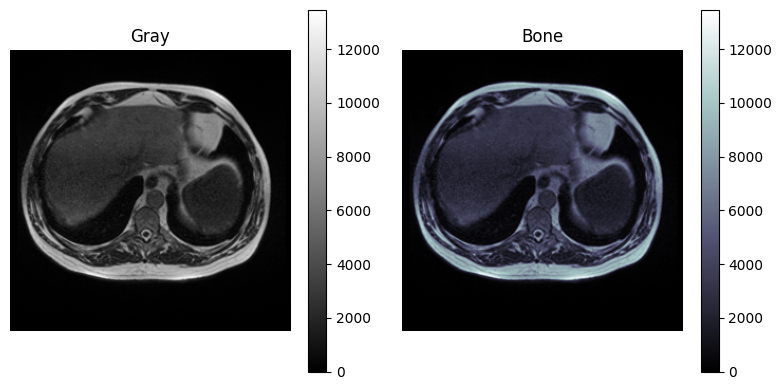

In [17]:
full_image_file_path = DIR_PATH + "train/case123/case123_day20/scans/slice_0065_266_266_1.50_1.50.png"

img = cv2.imread(full_image_file_path, cv2.IMREAD_UNCHANGED)
# default imread mode is IMREAD_COLOR which expects 8-bit 3 channel image, our input image is 16-bit grayscale which requires IMREAD_UNCHANGED

print(img.shape)
print(img)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Gray')
plt.axis('off')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(img, cmap='bone')
plt.title('Bone')
plt.axis('off')
plt.colorbar()

# while gray cmap is technically most correct for 16-bit grayscale image, using bone cmap from now on to enhance contrast visually

plt.tight_layout()
plt.show()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(266, 266)
255
[[3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]
(266, 266)
255
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
(266, 266)
255


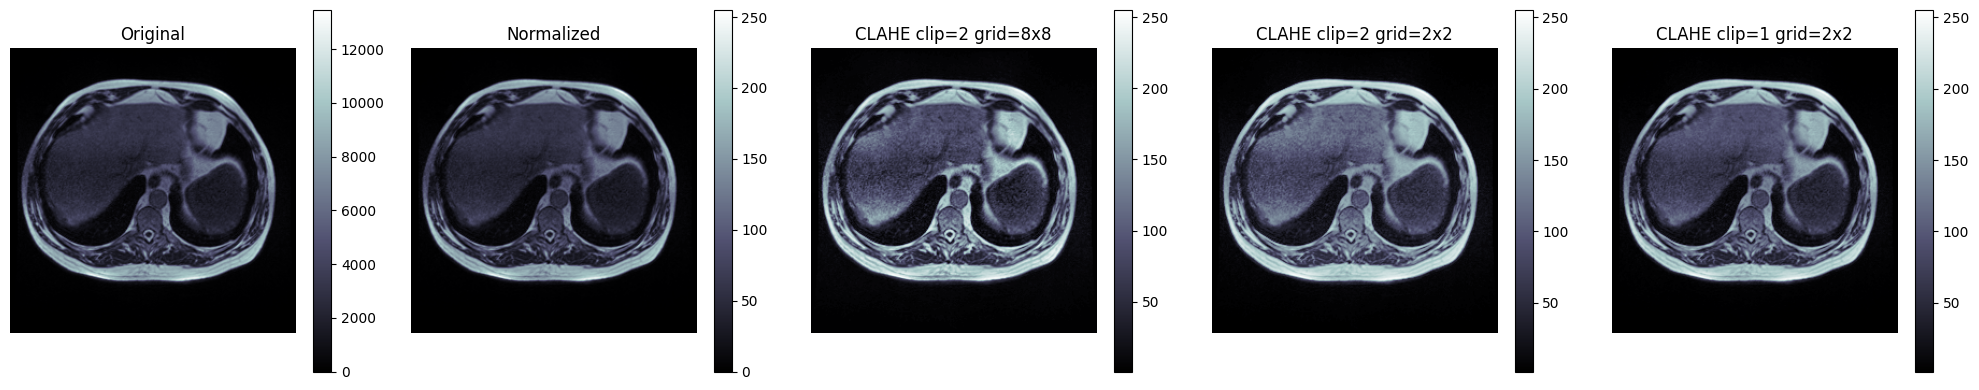

In [18]:
img = cv2.imread(full_image_file_path, cv2.IMREAD_UNCHANGED)

img_norm = cv2.normalize(img.astype('float32'), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX).astype(np.uint8)
print(img_norm)
print(img_norm.shape)
print(max([max(r) for r in img_norm]))

clahe1 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe2 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(2,2))
clahe3 = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(2,2))

res1 = clahe1.apply(img_norm)
res2 = clahe2.apply(img_norm)
res3 = clahe3.apply(img_norm)

print(res1)
print(res1.shape)
print(max([max(r) for r in res1]))

print(res2)
print(res2.shape)
print(max([max(r) for r in res2]))

# Show results
plt.figure(figsize=(20, 4))
for i, (title, im) in enumerate(zip(['Original', 'Normalized', 'CLAHE clip=2 grid=8x8', 'CLAHE clip=2 grid=2x2', 'CLAHE clip=1 grid=2x2'], [img, img_norm, res1, res2, res3])):
    plt.subplot(1,5,i+1)
    plt.imshow(im, cmap='bone')
    plt.title(title)
    plt.colorbar()
    plt.axis('off')
plt.tight_layout()
plt.show()

Based on the above figures, decided to use CLAHE clip=1 grid=2x2 for best visualization

## display_image

In [19]:
def display_image(id_, data, pred_mask=None, apply_CLAHE=False,
                  show_orig_img=True, show_true_mask=True, show_pred_mask=False):
	
	data_subset = data.loc[data.id == id_]
	
	img = cv2.imread(data_subset.image_path.iloc[0], cv2.IMREAD_UNCHANGED)
	img = cv2.normalize(img.astype('float32'), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX).astype(np.uint8)

	if apply_CLAHE:
		clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(2,2))
		img = clahe3.apply(img)
	
	mask = get_mask(id_, data)

	plt.figure(figsize=(9, 3))
	
	i = 1
	if show_orig_img:
		plt.subplot(1, 3, i)
		i += 1
		plt.imshow(img, cmap='bone')
		plt.title(f'{id_} image')
		plt.axis('off')

	if show_true_mask:
		plt.subplot(1, 3, i)
		i += 1
		plt.imshow(img, cmap='bone')
		plt.title('Image with true mask')
		plt.imshow(mask[..., 0], cmap=CMAP1)
		plt.imshow(mask[..., 1], cmap=CMAP2)
		plt.imshow(mask[..., 2], cmap=CMAP3)
		
		handles = [
		    Rectangle((0, 0), 1, 1, color=CMAP1(1.0)),
		    Rectangle((0, 0), 1, 1, color=CMAP2(1.0)),
		    Rectangle((0, 0), 1, 1, color=CMAP3(1.0))
		]
		labels = ['Large Bowel', 'Small Bowel', 'Stomach']
		plt.axis('off')
		plt.legend(handles, labels, bbox_to_anchor=(1.0, -0.4), loc='lower right', borderaxespad=0.)
	
	if show_pred_mask and pred_mask is not None:
		plt.subplot(1, 3, i)
		plt.imshow(img, cmap='bone')
		plt.title('Image with predicted mask')
		plt.imshow(pred_mask[..., 0], cmap=CMAP1)
		plt.imshow(pred_mask[..., 1], cmap=CMAP2)
		plt.imshow(pred_mask[..., 2], cmap=CMAP3)
		
		handles = [
		    Rectangle((0, 0), 1, 1, color=CMAP1(1.0)),
		    Rectangle((0, 0), 1, 1, color=CMAP2(1.0)),
		    Rectangle((0, 0), 1, 1, color=CMAP3(1.0))
		]
		labels = ["Large Bowel", "Small Bowel", "Stomach"]
		plt.axis('off')
		plt.legend(handles, labels, bbox_to_anchor=(1.0, -0.4), loc='lower right', borderaxespad=0.)
	
	
	plt.tight_layout()
	plt.show()	

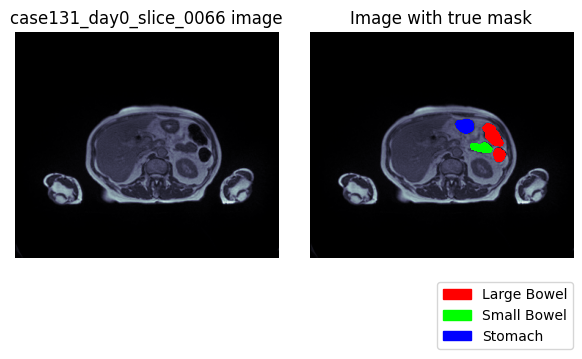

In [20]:
display_image('case131_day0_slice_0066', data)

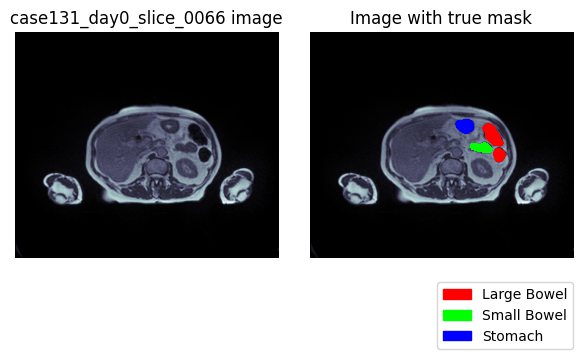

In [21]:
display_image('case131_day0_slice_0066', data, apply_CLAHE=True)

In [22]:
# testing pred_mask display using true mask
# display_image('case131_day0_slice_0066', data, pred_mask=get_mask('case131_day0_slice_0066', data),
#               show_pred_mask=True, apply_CLAHE=True)

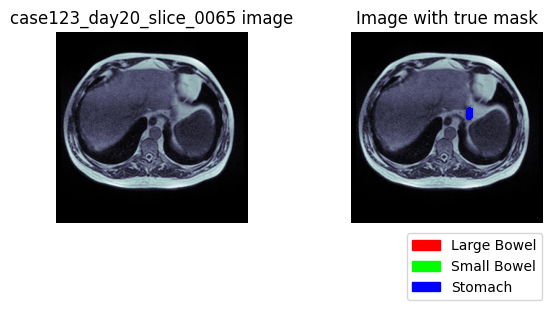

In [23]:
# example image with only stomach segment
display_image('case123_day20_slice_0065', data, apply_CLAHE=True)

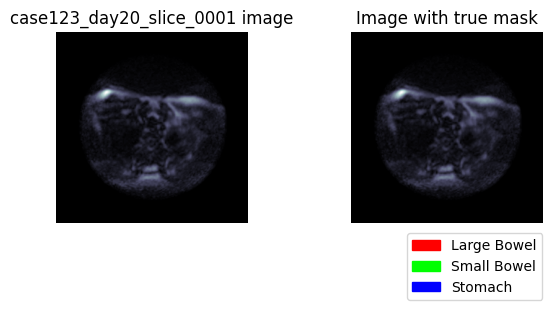

In [24]:
# example image without any segment
display_image('case123_day20_slice_0001', data, apply_CLAHE=True)

## display_multiple_slices

In [25]:
def display_multiple_slices(id_array, data, apply_CLAHE=False,
							show_pred_mask=False, pred_mask_array=None):

	'''
	id_array : an array of ids like case123_day20_slice_0001
	data     : dataframe containing all the image metadata 
	apply_CLAHE : whether or not to apply CLAHE
	show_pred_mask : if this parameter is False, then true mask will be shown
					 if it is True, masks from pred_mask_array will be shown
	pred_mask_array : array of prediction masks
	'''

	l = len(id_array)
	rows = np.ceil(l/5).astype(int)
	max_cols = 5
	data_subset = data.loc[data.id.isin(id_array), ]

	plt.figure(figsize=(5*3, rows*3))

	for i in range(l):
		
		img = cv2.imread(data_subset.image_path.iloc[3*i], cv2.IMREAD_UNCHANGED) # 3*i because every 3 image paths are same 
																				 #     and we read 1st entry only
		img = cv2.normalize(img.astype('float32'), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX).astype(np.uint8)

		if apply_CLAHE:
			clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(2,2))
			img = clahe3.apply(img)

		id_ = data_subset.id.iloc[3*i]

		if show_pred_mask:
			mask = pred_mask_array[3*i]
		else:
			mask = get_mask(id_, data)

		plt.subplot(rows, max_cols, i+1)
		plt.imshow(img, cmap='bone')
		plt.title(id_)
		plt.imshow(mask[..., 0], cmap=CMAP1)
		plt.imshow(mask[..., 1], cmap=CMAP2)
		plt.imshow(mask[..., 2], cmap=CMAP3)
		plt.axis('off')

		if i == 0:
			handles = [
				Rectangle((0, 0), 1, 1, color=CMAP1(1.0)),
				Rectangle((0, 0), 1, 1, color=CMAP2(1.0)),
				Rectangle((0, 0), 1, 1, color=CMAP3(1.0))
			]
			labels = ['Large Bowel', 'Small Bowel', 'Stomach']
		
			plt.legend(handles, labels, bbox_to_anchor=(0.0, 1.5), loc='upper left', borderaxespad=0.)
	
	plt.tight_layout()
	plt.show()	

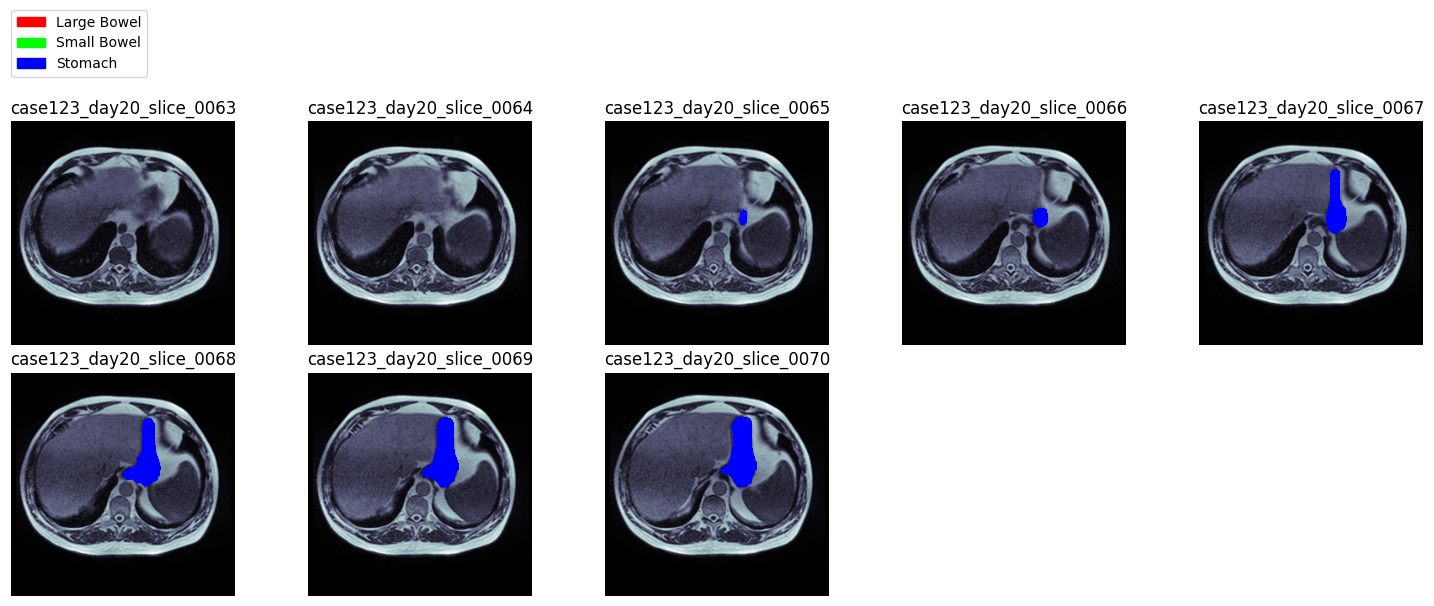

In [26]:
# using the below data to visualize change in segmentation mask across different slices
# data.query("case == 123 and day == 20 and slice >= 63 and slice <= 70")
display_multiple_slices(data.query("case == 123 and day == 20 and slice >= 63 and slice <= 70").id.unique(), 
                        data, apply_CLAHE=True)

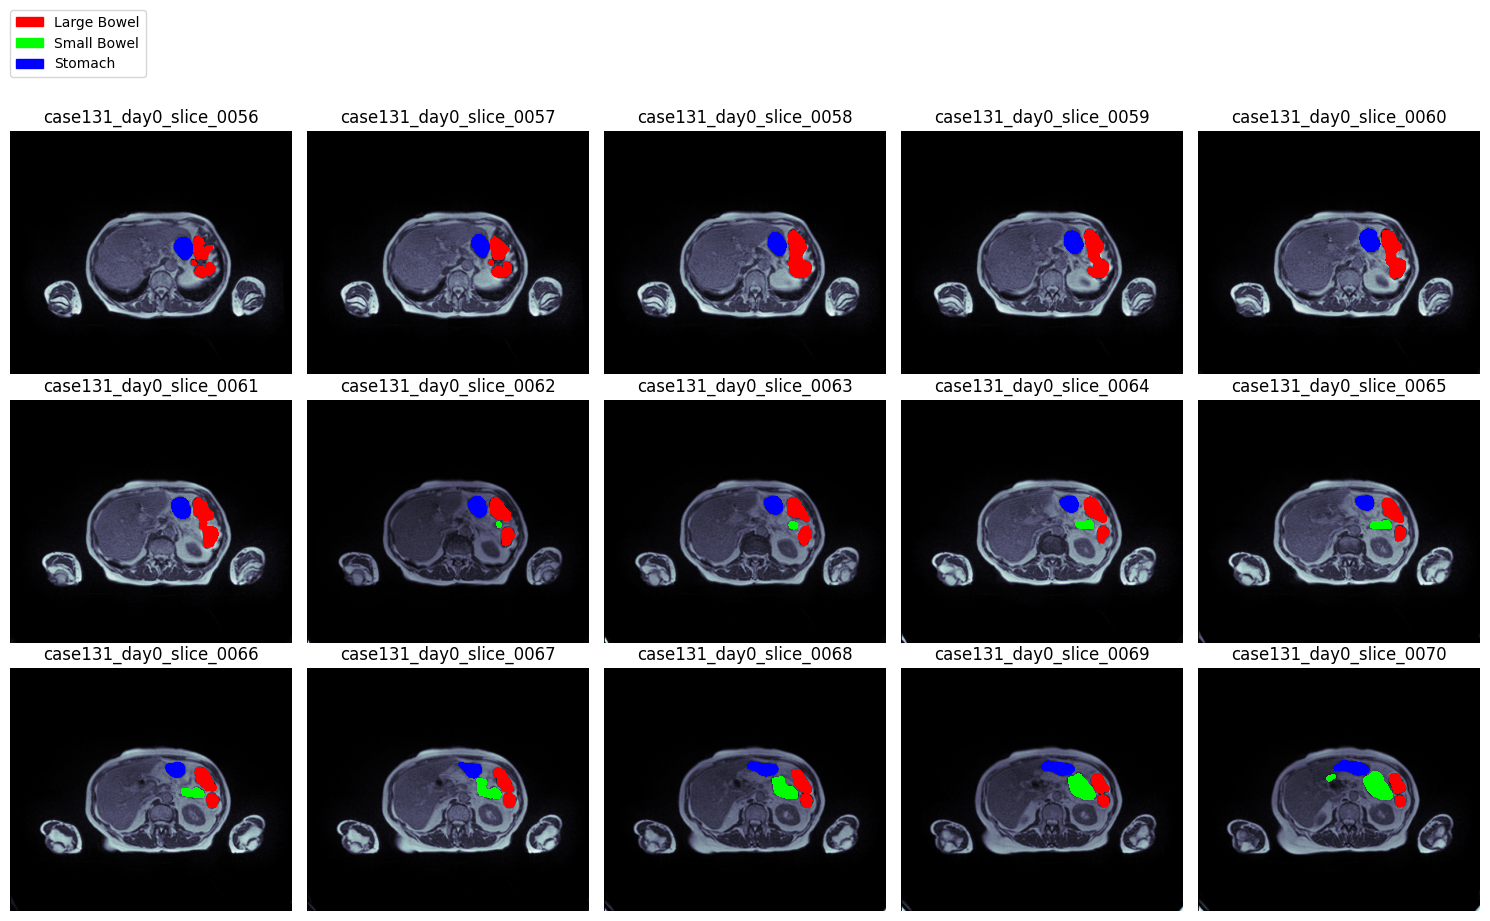

In [27]:
# using the below data to visualize change in segmentation mask across different slices - for a case where all masks are present
# data.query("case == 131 and day == 0 and slice > 60 and slice <= 70")
display_multiple_slices(data.query("case == 131 and day == 0 and slice > 55 and slice <= 70").id.unique(), 
                        data, apply_CLAHE=True)

## EDA

In [28]:
data.loc[data.segmentation.isna(), :]

,id,class,segmentation,case,day,slice,image_path,slice_w,slice_h,px_w,px_h
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png,266,266,1.5,1.5
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png,266,266,1.5,1.5
2,case123_day20_slice_0001,stomach,NaN,123,20,1,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png,266,266,1.5,1.5
3,case123_day20_slice_0002,large_bowel,NaN,123,20,2,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0002_266_266_1.50_1.50.png,266,266,1.5,1.5
4,case123_day20_slice_0002,small_bowel,NaN,123,20,2,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0002_266_266_1.50_1.50.png,266,266,1.5,1.5
...,...,...,...,...,...,...,...,...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN,30,0,143,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0143_266_266_1.50_1.50.png,266,266,1.5,1.5
115484,case30_day0_slice_0143,stomach,NaN,30,0,143,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0143_266_266_1.50_1.50.png,266,266,1.5,1.5
115485,case30_day0_slice_0144,large_bowel,NaN,30,0,144,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0144_266_266_1.50_1.50.png,266,266,1.5,1.5
115486,case30_day0_slice_0144,small_bowel,NaN,30,0,144,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0144_266_266_1.50_1.50.png,266,266,1.5,1.5


In [29]:
# How many missing values
data.isna().sum()

id                  0
class               0
segmentation    81575
case                0
day                 0
slice               0
image_path          0
slice_w             0
slice_h             0
px_w                0
px_h                0
dtype: int64

Only segmentation column contains NaN / missing values

In [30]:
print(f'Num cases : {len(data.case.unique())} \
        Num days : {len(data.day.unique())}   \
        Num slices : {len(data.slice.unique())}')

Num cases : 85         Num days : 35           Num slices : 144


,missing_seg_mask,count,percent
0,True,81575,70.635044
1,False,33913,29.364956


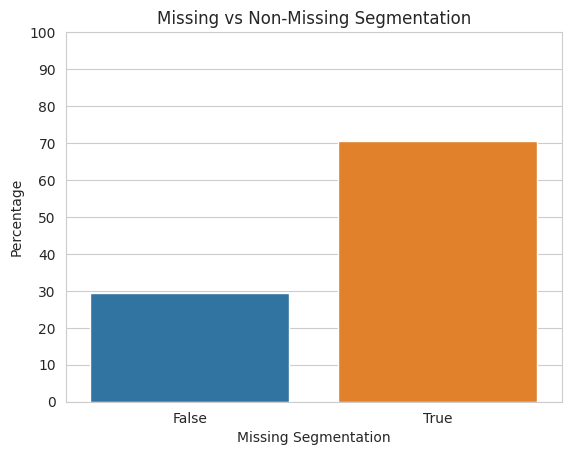

In [44]:
na_counts = data.segmentation.isna().value_counts().rename_axis('missing_seg_mask').reset_index(name='count')

# Add percentage column
na_counts['percent'] = 100 * na_counts['count'] / na_counts['count'].sum()

display(na_counts)

# Plot
sns.set_style("whitegrid") 

sns.barplot(data=na_counts, x='missing_seg_mask', y='percent')
plt.ylabel('Percentage')
plt.xlabel('Missing Segmentation')
plt.title('Missing vs Non-Missing Segmentation')
plt.yticks(range(0, 105, 10))
plt.show()

Approximately 70% of entries have missing segmentation masks

In [32]:
data['class'].value_counts()

class
large_bowel    38496
small_bowel    38496
stomach        38496
Name: count, dtype: int64

As expected (previously seen that number of rows in data df is 3x that of path_df), all 3 segmentation classes have equal number of entries.

,class,missing_seg_mask,count,percent
0,large_bowel,True,24411,63.411783
1,large_bowel,False,14085,36.588217
2,small_bowel,True,27295,70.903470
3,small_bowel,False,11201,29.096530
4,stomach,True,29869,77.589879
5,stomach,False,8627,22.410121


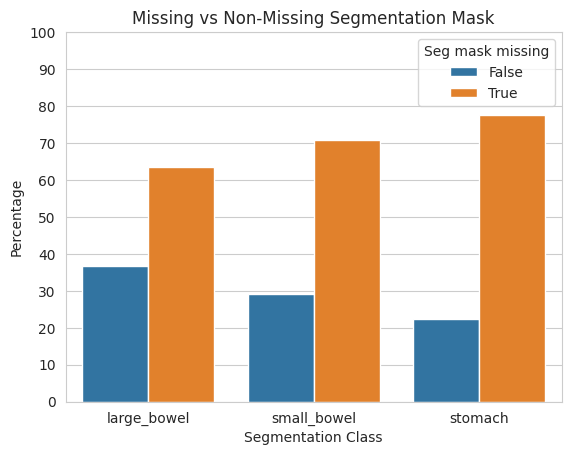

In [50]:
na_counts = (
    data.groupby('class')['segmentation']
    .apply(lambda s: s.isna().value_counts())
    .rename_axis(index=['class', 'missing_seg_mask'])
    .reset_index(name='count')
)
na_counts['percent'] = 100 * na_counts['count'] / na_counts.groupby('class')['count'].transform('sum')
display(na_counts)

sns.barplot(data=na_counts, x='class', y='percent', hue='missing_seg_mask')
plt.ylabel('Percentage')
plt.xlabel('Segmentation Class')
plt.title('Missing vs Non-Missing Segmentation Mask')
plt.legend(title="Seg mask missing")
plt.yticks(range(0, 105, 10))
plt.show()

# References
* https://www.kaggle.com/code/awsaf49/uwmgi-mask-data
* https://www.kaggle.com/code/paulorzp/run-length-encode-and-decode
* https://www.kaggle.com/code/awsaf49/uwmgi-unet-train-pytorch
* https://www.kaggle.com/code/andradaolteanu/aw-madison-eda-in-depth-mask-exploration
* https://www.kaggle.com/code/masatomurakawamm/uwmgi-pspnet-u-net-deeplabv3-swin-unet